In [1]:
import os
import sys
import time

import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import rotate as sc_rotate
from torchvision import datasets, transforms
from scipy.optimize import curve_fit, least_squares, minimize

from pandas import read_fwf, DataFrame

In [2]:
from radioreader import *
from methods import *
from kittler import kittler_float

In [3]:
directory = 'unlrg'
ext = 'fits'
names = glob.glob('{0}/*.{1}*'.format(directory, ext))

In [5]:
images = []
for n in tqdm(range(len(names))):
    im = readImg(names[n], normalize=True, sz=128)
    k = kittler_float(im, copy=False)
    images.append( np.expand_dims(k, axis=0) )
    del im
    del k
# images = np.array(images)

In [6]:
im_tensor = torch.tensor(images)
im_tensor.shape

torch.Size([14245, 1, 128, 128])

In [7]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

#arguments
batch_size = 64
test_batch_size = 64

ts = list(im_tensor.shape)
imh, imw = ts[2], ts[3]
print(im_tensor.shape)
print('imh, imw = ',imh, imw)

epochs = 15
learning_rate = 0.001
momentum = 0.9 # 'SGD momentum'
latent_space=16

cuda
torch.Size([14245, 1, 128, 128])
imh, imw =  128 128


In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, height, width, device, latent_dim=16):
        super(AutoEncoder, self).__init__()

        self.height = height
        self.width = width
        self.device = device
        

        self.feat_sz = (self.height // 2**3) * (self.width // 2**3)
        
        filter_arr = [8, 16, 16]#, 16, 16]
        self.max_channels = filter_arr[-1]
        
        # Init model layers
        self.down1 = nn.Conv2d(           1,  filter_arr[0], 3, stride=2,padding=1) #shape -2
        self.down2 = nn.Conv2d(filter_arr[0], filter_arr[1], 3, stride=2,padding=1) #shape -2
        self.down3 = nn.Conv2d(filter_arr[1], filter_arr[2], 3, stride=2,padding=1) #shape -2
#         self.down4 = nn.Conv2d(filter_arr[2], filter_arr[3], 3, stride=2,padding=1) #shape -2
#         self.down5 = nn.Conv2d(filter_arr[3], filter_arr[4], 3, stride=2,padding=1) #shape -2
        
        self.latentd = nn.Linear(self.max_channels * self.feat_sz, latent_dim)
        #decoder
        self.latentu = nn.Linear(latent_dim, self.feat_sz * self.max_channels)
        
        other_opts = {'stride':2, 'padding':1, 'output_padding':1}
        
#         self.up5   = nn.ConvTranspose2d(filter_arr[4], filter_arr[3], 3, **other_opts)
#         self.up4   = nn.ConvTranspose2d(filter_arr[3], filter_arr[2], 3, **other_opts)
        self.up3   = nn.ConvTranspose2d(filter_arr[2], filter_arr[1], 3, **other_opts)
        self.up2   = nn.ConvTranspose2d(filter_arr[1], filter_arr[0], 3, **other_opts)
        self.up1   = nn.ConvTranspose2d(filter_arr[0],             1, 3, **other_opts)
        
    def encode(self, x, params):
        x = F.relu(self.down1(x))
        x = F.relu(self.down2(x))
        x = F.relu(self.down3(x))
#         x = F.relu(self.down4(x))
#         x = F.relu(self.down5(x))
        x =  x.view(-1, self.max_channels * self.feat_sz) #flatten
        x = self.latentd(x)
        x = self.feature_transformer(x, params)
        return x
    
    def decode(self, x):
        x = self.latentu(x)
        x = x.view(-1, self.max_channels, (self.height // 2**3), (self.width // 2**3))
#         x = F.relu(self.up5(x))
#         x = F.relu(self.up4(x))
        x = F.relu(self.up3(x))
        x = F.relu(self.up2(x))
        x = torch.sigmoid(self.up1(x))
        return x

    def forward(self, x, params):
        return self.decode(self.encode(x, params))
    
    def feature_transformer(self, input, params):
        """For now we assume the params are just a single rotation angle

        Args:
            input: [N,c] tensor, where c = 2*int
            params: [N,1] tensor, with values in [0,2*pi)
        Returns:
            [N,c] tensor
        """
        # First reshape activations into [N,c/2,2,1] matrices
        x = input.view(input.size(0), input.size(1)//2 , 2 ,1)
        # Construct the transformation matrix
        sin = torch.sin(params)
        cos = torch.cos(params)
        transform = torch.cat([sin, -cos, cos, sin], 1)
        transform = transform.view(transform.size(0),1,2,2).to(self.device)
        # Multiply: broadcasting taken care of automatically
        # [N,1,2,2] @ [N,channels/2,2,1]
#         print(transform.shape, x.shape)
        output = torch.matmul(transform, x)
        # Reshape and return
        return output.view(input.size())

In [9]:
def rotate_tensor(input):
    """Nasty hack to rotate images in a minibatch, this should be parallelized
    and set in PyTorch

    Args:
        input: [N,c,h,w] **numpy** tensor
    Returns:
        rotated output and angles in radians
    """
    angles = 2*np.pi*np.random.rand(input.shape[0])
    angles = angles.astype(np.float32)
    outputs = []
    for i in range(input.shape[0]):
        output = sc_rotate(input[i,...], 180*angles[i]/np.pi, axes=(1,2), reshape=False)
        outputs.append(output)
    return np.stack(outputs, 0), angles

def random_rotate(input):
    angle = 2*np.pi*np.random.rand().astype(np.float32)
    for i in range(input.shape[0]):
        output = sc_rotate(input[i,...], 180 * angle/np.pi, axes=(1,2), reshape=False)
        outputs.append(output)
    return np.stack(outputs, 0)

In [10]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        # Reshape data
        targets, angles = rotate_tensor(data.numpy())
        targets = torch.from_numpy(targets).to(device, dtype=torch.float)
        angles = torch.from_numpy(angles).to(device)
        angles = angles.view(angles.size(0), 1)

        # Forward pass
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        output = model(data, angles)

        # Binary cross entropy loss
        loss_fnc = nn.BCELoss(reduction='sum')
        loss = loss_fnc(output, targets)

        # Backprop
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            sys.stdout.write('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'
                .format(epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            sys.stdout.flush()

In [11]:
model = AutoEncoder(imh, imw, device, latent_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(im_tensor, batch_size=batch_size, shuffle=True)

In [12]:
%%time
for epoch in range(1, 51):
    start = time.time()
    train(model, device, train_loader, optimizer, epoch)
    end = time.time()
    sys.stdout.write('\n Time: {0:.2f}s\n'.format(end - start))

# model.load_state_dict(torch.load('unlrg_linear_model_mcr', map_location=torch.device('cpu')))
# print(model.eval())

Train Epoch: 1 [14080/14245 (99%)]	Loss: 12096.762695
 Time: 30.78s
Train Epoch: 2 [14080/14245 (99%)]	Loss: 12452.093750
 Time: 29.98s
Train Epoch: 3 [14080/14245 (99%)]	Loss: 9768.3056647
 Time: 29.69s
Train Epoch: 4 [14080/14245 (99%)]	Loss: 12429.186523
 Time: 29.50s
Train Epoch: 5 [14080/14245 (99%)]	Loss: 9061.5898448
 Time: 29.69s
Train Epoch: 6 [14080/14245 (99%)]	Loss: 10758.441406
 Time: 29.53s
Train Epoch: 7 [14080/14245 (99%)]	Loss: 10426.833008
 Time: 29.63s
Train Epoch: 8 [14080/14245 (99%)]	Loss: 8024.3544921
 Time: 29.65s
Train Epoch: 9 [14080/14245 (99%)]	Loss: 10249.618164
 Time: 29.70s
Train Epoch: 10 [14080/14245 (99%)]	Loss: 8162.4580088
 Time: 29.53s
Train Epoch: 11 [14080/14245 (99%)]	Loss: 9863.2978526
 Time: 29.64s
Train Epoch: 12 [14080/14245 (99%)]	Loss: 8341.2558593
 Time: 29.65s
Train Epoch: 13 [14080/14245 (99%)]	Loss: 7999.1855474
 Time: 29.62s
Train Epoch: 14 [14080/14245 (99%)]	Loss: 7931.8144538
 Time: 29.71s
Train Epoch: 15 [14080/14245 (99%)]	Loss: 1

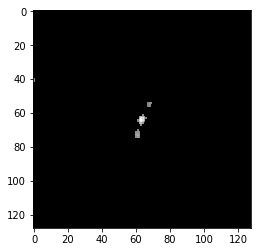

In [13]:
l = next(iter(train_loader))
l00 = l[0,:,:]
plt.imshow(l00.numpy()[0,:,:], cmap='gray')
plt.show()

In [14]:
n_rot = 32
with torch.no_grad():
    angles = torch.linspace(0, 2*np.pi, steps=n_rot)
    angles = angles.view(n_rot, 1)

    data = l00
    data = data.view(data.size(0), -1)
    data = data.repeat(n_rot, 1)
    data = data.view(-1, 1, imh, imw).to(device, dtype=torch.float)

    output = model.encode(data, angles)
    output = output.cpu()

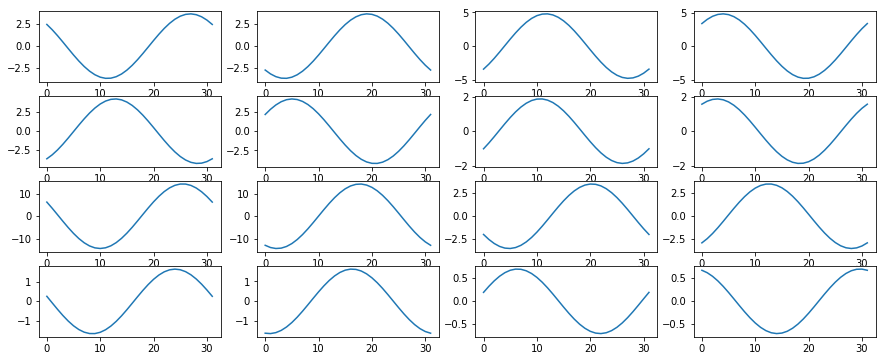

In [ ]:
o_np = output.numpy()
f, ax = plt.subplots(4, 4, figsize=(15, 6))
for i in range(4): 
    for j in range(4):
        ax[i][j].plot(o_np[:,-i*4 + j])

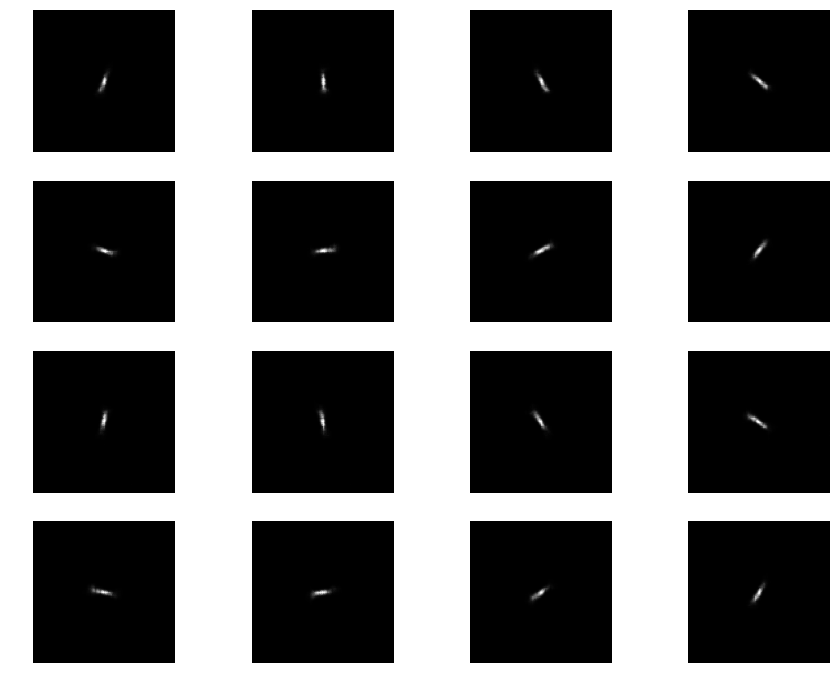

In [ ]:
with torch.no_grad():
    dec = model.decode(output.to(device))
    dec = dec.cpu().view(-1,1,imh,imw)
d_np = dec.numpy()

f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(d_np[2*(i*4 + j),0], cmap='gray')
        ax[i][j].axis('off')

In [ ]:
o_np.shape

(32, 64)

In [ ]:
torch.save(model.state_dict(), 'unlrg_linear_model_mcr')

In [ ]:
def sin_func(x, a=1, c=0):
    return a * np.sin(x + c*np.pi / 180)
x_data = np.linspace(0, 2 * np.pi, n_rot)

In [ ]:
o_np.shape

(32, 64)

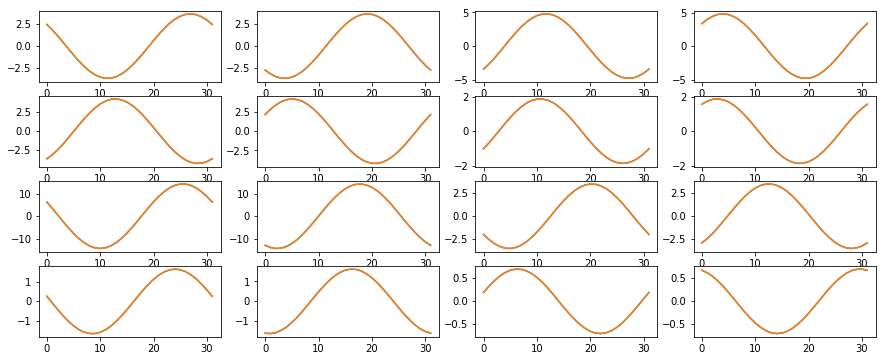

In [ ]:
f, ax = plt.subplots(4, 4, figsize=(15, 6))
for i in range(4): 
    for j in range(4):
        y_dt = o_np[:,-i*4 + j]
        fit = curve_fit(sin_func, x_data, y_dt, bounds=(0,[np.inf, 360]))[0]
        
        ax[i][j].plot(y_dt)
        ax[i][j].plot(sin_func(x_data, *fit))

In [ ]:
fits = []
for i in tqdm(range(o_np.shape[1])):
    y_dt = o_np[:,-i]
    fit  = curve_fit(sin_func, x_data, y_dt, bounds=(0,[np.inf, 360]))[0]
    fits.append(fits)
fits = np.array(fits)

In [ ]:
fits[:,1] -= fits[:,1][0]

In [ ]:
def get_val_generator(fit):
    def gen(v):
        vals = np.zeros((fit.shape[0]))
        for i in range(len(vals)):
            vals[i] = sin_func(v, *fit[i])
        return vals
    return gen

In [ ]:
gen = get_val_generator(fits)

In [ ]:
g = gen(0)

def get_decoded_image(code, model):
    with torch.no_grad():
        dt  = torch.from_numpy(code)
        dec = model.decode(dt.to(device, dtype=torch.float))
        dec = dec.cpu().view(-1,1,imh,imw)
    d_np = dec.numpy()
    return d_np[0,0]

f, ax = plt.subplots(16, 11, figsize=(16, 24))
for i in range(16): 
    for j in range(11):
        g = gen(0)
        v = 20*(j - 5)
        g[i] = g[i] + v
        d_m = get_decoded_image(g, model)
#         ax[i][j].imshow(d_m, cmap='gray')
#         ax[i][j].axis('off')
#         ax[i][j].set_title(v)

In [ ]:
d = get_decoded_image(np.zeros((16)))
plt.imshow(d, cmap='gray')
plt.show()

In [ ]:
f, ax = plt.subplots(16, 11, figsize=(16, 24))
for i in range(16): 
    for j in range(11):
        g = np.zeros((16))
        v = 20*(j - 5)
        g[i] = g[i] + v
        d_m = get_decoded_image(g)
        ax[i][j].imshow(d_m, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title(v)

In [ ]:
f, ax = plt.subplots(1, 11, figsize=(16, 24))
for j in range(11):
    v = 20*(j - 5)
    g = np.ones((16)) * v
    d_m = get_decoded_image(g, model)
    ax[j].imshow(d_m, cmap='gray')
    ax[j].axis('off')
    ax[j].set_title(v)

# Load LRG by class

In [ ]:
lrg = read_fwf('catalog/mrt-table3.txt', skiprows=41, header=None)
labeled = DataFrame({'Name':lrg[0], 'Label':lrg[7]})

In [ ]:
n_tyepes = 6
names = [[]] * n_tyepes
for i in range(n_tyepes):
    l1 = labeled['Label'] == str(i + 1)
    names[i] = labeled[l1]['Name'].tolist()

In [ ]:
directory = 'lrg'
ext = 'fits'

images_s = []

for i in tqdm(range(n_tyepes)):
    images = []
    for name in names[i]:
        f_name = '{0}/{1}.{2}'.format(directory, 
                                      name.replace('.','_'), ext)
        im = readImg(f_name, normalize=True, sz=128)
        k = kittler_float(im, copy=False)
        images.append(k)
    images_s.append(np.array(images))

In [ ]:
f, ax = plt.subplots(1, 11, figsize=(22, 2))
for i in range(11):
    ax[i].imshow(images_s[3][i], cmap='gray')
    ax[i].axis('off')
plt.show()

In [ ]:
def get_rot_data(n_rot, data):
    data = torch.from_numpy(data)
    with torch.no_grad():
        angles = torch.linspace(0, 2*np.pi, steps=n_rot)
        angles = angles.view(n_rot, 1)

        data = data.view(data.size(0), -1)
        data = data.repeat(n_rot, 1)
        data = data.view(-1, 1, imh, imw).to(device, dtype=torch.float)

        output = model.encode(data, angles)
        output = output.cpu().numpy()
    return output

In [ ]:
o_np = get_rot_data(32, images_s[3][0:1])

In [ ]:
fits_20 = []
for z, img in enumerate(tqdm(images_s[2][:50])):
    o_np = get_rot_data(32, np.expand_dims(img, 0))
    fits_l = []
    for i in range(16): 
        y_dt = o_np[:, i]
        fit = curve_fit(sin_func, x_data, y_dt, bounds=(0,[np.inf, 360]))[0]
        fits_l.append(fit)
    fits_20.append(np.array(fits_l))
fits_20 = np.array(fits_20)
print(fits_20.shape)

In [ ]:
for i in range(len(fits_20)):
    fits_20[i][:, 1] -= fits_20[i][:, 1][0]
# fits_20[1][:,1] -= fits_20[1][:,1]
# fits_20[0][:, 1] -= fits_20[0][:, 1][0]

In [ ]:
# f, ax = plt.subplots(2, 11, figsize=(16, 3))
# for j in range(11):
#     gen = get_val_generator(fits_20[j])
#     g = gen(0)
#     d_m = get_decoded_image(g, model)
    
#     ax[0][j].imshow(images_s[2][j], cmap='gray')
#     ax[0][j].axis('off')
    
#     ax[1][j].imshow(d_m, cmap='gray')
#     ax[1][j].axis('off')

In [ ]:
# o_np = output.numpy()
f, ax = plt.subplots(4, 4, figsize=(15, 6))
for f in fits_20[:10]:
    for i in range(4): 
        for j in range(4):
            ax[i][j].plot(sin_func(x_data, *f[i*4 + j]))

In [ ]:
fit_avg = np.average(fits, axis=0)

f, ax = plt.subplots(4, 4, figsize=(15, 6))
for i in range(4): 
    for j in range(4):
        ax[i][j].plot(sin_func(x_data, *fit_avg[i*4 + j]))

In [ ]:
gen = get_val_generator(fit_avg)
g = gen(0)
im_avg = get_decoded_image(g, model)
plt.imshow(im_avg, cmap='gray')
plt.show()